<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Directories-setting" data-toc-modified-id="Directories-setting-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Directories setting</a></span></li><li><span><a href="#Corresponding-JSON-file-to-extract-labels" data-toc-modified-id="Corresponding-JSON-file-to-extract-labels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Corresponding JSON file to extract labels</a></span></li><li><span><a href="#Advanced-model-construction" data-toc-modified-id="Advanced-model-construction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Advanced model construction</a></span><ul class="toc-item"><li><span><a href="#Tokenization" data-toc-modified-id="Tokenization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Tokenization</a></span></li><li><span><a href="#Split-data" data-toc-modified-id="Split-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Split data</a></span></li><li><span><a href="#Train-Our-Classification-Model" data-toc-modified-id="Train-Our-Classification-Model-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Train Our Classification Model</a></span></li><li><span><a href="#Models'-parameters" data-toc-modified-id="Models'-parameters-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Models' parameters</a></span></li><li><span><a href="#Training-proecess" data-toc-modified-id="Training-proecess-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Training proecess</a></span></li></ul></li><li><span><a href="#Validate-model" data-toc-modified-id="Validate-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validate model</a></span></li><li><span><a href="#Saving-model" data-toc-modified-id="Saving-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Saving model</a></span></li><li><span><a href="#Load-trained-model-to-predict" data-toc-modified-id="Load-trained-model-to-predict-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Load trained model to predict</a></span></li><li><span><a href="#Visualization-from-runs" data-toc-modified-id="Visualization-from-runs-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualization from <code>runs</code></a></span></li><li><span><a href="#Befor-fine-tuning-model" data-toc-modified-id="Befor-fine-tuning-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Befor fine-tuning model</a></span></li></ul></div>

Please check parameters first, then to run other cells

# Parameters

In [1]:
import torch
import os
def sci_format(number_in_scientific_notation):
  # Convert the number to a string in scientific notation
  number_str = "{:.1e}".format(number_in_scientific_notation)

  # Check if the exponent contains a leading zero
  if "e-0" in number_str:
      # Remove the leading zero from the exponent
      formatted_exponent = number_str.replace("e-0", "e-")
  else:
      formatted_exponent = number_str

  # Check if the formatted exponent has a decimal point
  if "." in formatted_exponent:
      # Remove the decimal point and extra zeros from the exponent
      formatted_number_str = formatted_exponent.replace(".0e", "e").replace("0e", "e")
  else:
      formatted_number_str = formatted_exponent
  return formatted_number_str

# parameters for adjestment
labels_json = 'backup_23148_4374.json'
# maximun token sequence length
MAX_LENGTH_SEQ = 512
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 16
# Number of training epochs. The BERT authors recommend between 2 and 4.
# Depends on training criterian
epochs = 6

learning_rate = 1.3e-5 # args.learning_rate - default is 5e-5, our notebook would adjust
eps = 1e-7 # args.adam_epsilon  - default is 1e-8.
lr_format = sci_format(learning_rate)
# training records
# a = advance, text = textual approachs, e = epoch, s = sequence length, lr = learning rate
runs_name = f'a_text_e{epochs}_s{MAX_LENGTH_SEQ}_lr{lr_format}'
print(runs_name)

# Saving training process steps and validation process steps
runs_output = f"./output/runs/{runs_name}"
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = f'./output/checkpoints/{runs_name}'

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


a_text_e6_s512_lr1.3e-5
No GPU available, using the CPU instead.


# Directories setting

In [2]:
from typing import List
import pandas as pd
import numpy as np
import ast
import re

source_dir = './output'
labels_dir = os.path.join(source_dir, f"LABELS")
text_path = './alignment_pptx_list.csv'
def convert_to_list(data):
    return ast.literal_eval(data)
# Since it take too much time on traversal ppt files, Easily to import the dataframe from the csv file
df_da = pd.read_csv(text_path, converters={'shape_type': convert_to_list})

df_da = df_da[~df_da['contents'].isnull()]
df_da.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26468 entries, 0 to 26467
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   26468 non-null  object
 1   page_num    26468 non-null  int64 
 2   shape_type  26468 non-null  object
 3   contents    26468 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [3]:
# filter out less than 4 words
df_da['word_count'] = df_da['contents'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_few_words = df_da[~(df_da['word_count'] <= 4)]
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


# Corresponding JSON file to extract labels

In [ ]:
df_json = pd.read_json(os.path.join(labels_dir,'backup_23148_4374.json'))
# have done for annotations
df_json = df_json[df_json['annotations'].apply(lambda x: len(x) != 0)]
# annotation results exist
df_json = df_json[df_json['annotations'].apply(lambda x: len(x[0]['result']) != 0)]
# 22348 for 13th slide
count = 13

df_few_words['label'] = ''

for idx, row in enumerate(df_json.iterrows()):
  slide = row[1]
  image_path = slide['data']['image']
  choice = slide['annotations'][0]['result'][0]['value']['choices'][0]
  # print(image_path, choice)
  if image_path.find('22348')!=-1:
    # print(image_path, choice)
    new_image_name = image_path.split('.')[0] + '_' + str(count) + '.PNG'
    slide['data']['image'] = new_image_name
    image_path = new_image_name
    print(image_path)
    count += 1

  # get page number
  if image_path.split('.')[0].split('_')[-1].isdigit():
    page = int(image_path.split('.')[0].split('_')[-1])
  else:
    page = 0

  # given 'Angebot\ktr' as a condition
  ktr = image_path.split('-')[1].split('_')[0]
  ktr = 'Angebot\\'+ ktr
  ktr = re.escape(ktr)

  # some issues that it should modify manually
  if (ktr == '22348' and page == 13):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Initial Situation'
    continue
  elif (ktr == '22348' and page == 14):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Target Situation'
    continue

  df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = choice

df_few_words.info()

In [6]:
df_few_words['label'].value_counts()

                               18778
Working Package Examples         668
Others                           607
Working Package Description      564
Reference Details                407
Consultant Profile               370
Offer Title                      365
Project Calculation              304
Initial & Target Situation       255
Working Package Overview         237
Reference Overview               215
Competencies                     189
Target Situation                 103
Initial Situation                 86
Name: label, dtype: int64

In [7]:
df = df_few_words[(df_few_words['label']!='') & (df_few_words['label']!='Others')]

In [8]:
# split texts into several chunks
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else:
    n = 1

  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:128]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 128]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
labels = {'Competencies': 0,
            'Consultant Profile':1,
            'Initial & Target Situation':2,
            'Initial Situation':3,
            'Offer Title':4,
            'Project Calculation':5,
            'Reference Details':6,
            'Reference Overview':7,
            'Target Situation':8,
            'Working Package Description':9,
            'Working Package Examples':10,
            'Working Package Overview':11,
  }

df['label_encode'] = df['label'].apply(lambda x : labels[x])
df['split_contents'] = df['contents'].apply(lambda x :get_split(x))
df = df.explode('split_contents', ignore_index = True)
df.drop(columns = ['word_count'], inplace = True)

# Advanced model construction

In [ ]:
from transformers import BertTokenizer, BertTokenizerFast


tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

# class Dataset(torch.utils.data.Dataset):

#     def __init__(self, df):

#         self.labels = [labels[label] for label in df_few_words['category']]
#         self.texts = [tokenizer(text,
#                                 padding='max_length', max_length = 128, truncation=True,
#                                 return_tensors="pt") for text in df_few_words['contents']]

#     def classes(self):
#         return self.labels

#     def __len__(self):
#         return len(self.labels)

#     def get_batch_labels(self, idx):
#         # Fetch a batch of labels
#         return np.array(self.labels[idx])

#     def get_batch_texts(self, idx):
#         # Fetch a batch of inputs
#         return self.texts[idx]

#     def __getitem__(self, idx):

#         batch_texts = self.get_batch_texts(idx)
#         batch_y = self.get_batch_labels(idx)

#         return batch_texts, batch_y

In [11]:
df.head()

,file_name,page_num,shape_type,contents,label,label_encode,split_contents
0,C:\Users\Kun\Desktop\Angebot\10831\Enclosure 1...,1,"[PICTURE, FREEFORM, TEXT_BOX]",iCert 20 Change Management Design Sprint Sup...,Offer Title,4,iCert 20 Change Management Design Sprint Suppo...
1,C:\Users\Kun\Desktop\Angebot\10831\Enclosure 1...,2,"[PLACEHOLDER, AUTO_SHAPE, FREEFORM, TABLE, GRO...",B Intranet Create content and setup concept s...,Working Package Overview,11,B Intranet Create content and setup concept st...
2,C:\Users\Kun\Desktop\Angebot\10831\Enclosure 1...,4,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, TEXT_...",Thematic Focus Transformation change managemen...,Consultant Profile,1,Thematic Focus Transformation change managemen...
3,C:\Users\Kun\Desktop\Angebot\11137\Enclosure 1...,1,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, TEXT_BOX, E...",Secure Life Cycle Management LCM Process Enclo...,Offer Title,4,Secure Life Cycle Management LCM Process Enclo...
4,C:\Users\Kun\Desktop\Angebot\11137\Enclosure 1...,4,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEF...",Hamilton provides intelligent ventilation prod...,Initial & Target Situation,2,Hamilton provides intelligent ventilation prod...


In [ ]:
contents = df.split_contents.values
labels = df.label_encode.values

In [ ]:
# Print the original sentence.
print('Original: ', contents[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(contents[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contents[0])))

Original:  iCert 20 Change Management Design Sprint Support Enclosure 1 Service Description to offer No 10831 Munich 20th June 2022 UNITY AG
Tokenized:  ['i', '##C', '##ert', '20', 'Change', 'Management', 'Design', 'Sprint', 'Support', 'En', '##clo', '##sure', '1', 'Service', 'Description', 'to', 'offer', 'No', '108', '##31', 'Munich', '20th', 'June', '2022', 'UN', '##IT', '##Y', 'AG']
Token IDs:  [177, 10858, 11605, 10197, 23305, 16485, 17732, 44565, 39007, 10243, 63143, 47394, 122, 13489, 52976, 10114, 24443, 10657, 15845, 81456, 27349, 18604, 11120, 75632, 26578, 37611, 14703, 17935]


In [ ]:
# Measure the maximum sentence length.
max_len = 0

# For every sentence...
for sent in contents:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  365


## Tokenization

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in contents:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH_SEQ,    # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', contents[0])
print('Token IDs: ', input_ids[0])
print('attention maske: ', attention_masks[0])


## Split data

In [ ]:
from torch.utils.data import TensorDataset, random_split
torch.manual_seed(42)
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10 train-validation split as well as 10-testing split

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset, temp_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))

3,099 training samples
  387 validation samples
  388 testing samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create DataLoaders for training, validation, and testing
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

testing_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)
# save tensor for performance evaluation
torch.save(testing_dataloader, './output/others/text_test_dataloader.pth')

## Train Our Classification Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
        "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 12, # The number of output labels--12 for multi-class classification.

        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## Models' parameters

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [ ]:
from transformers import get_linear_schedule_with_warmup
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"

optimizer = AdamW(model.parameters(),
                  lr = learning_rate[0], # args.learning_rate - default is 5e-5
                  eps = eps # args.adam_epsilon  - default is 1e-8.
                )

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training proecess

In [ ]:
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(runs_output)

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Define early stopping variables
early_stop = False
best_val_loss = float('inf')  # Initialize with a high value
patience = 5  # Number of epochs to wait before stopping if no improvement
no_improvement_count = 0  # Counter for epochs with no improvement

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()


        # if step % 40 == 39: # every 40 mini-batches....
        if step % 40 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # ========================================
          #               Validation
          # ========================================
          # After the completion of each training epoch, measure our performance on
          # our validation set.
          print("")
          print(f"Running Validation...({step // 40})")

          t1 = time.time()

          # Put the model in evaluation mode--the dropout layers behave differently
          # during evaluation.
          model.eval()

          # Tracking variables
          total_eval_accuracy = 0
          total_eval_loss = 0
          predictions = []
          true_labels = []

          # Evaluate data for one epoch
          for batch in validation_dataloader:

              # Unpack this training batch from our dataloader.
              #
              # As we unpack the batch, we'll also copy each tensor to the GPU using
              # the `to` method.
              #
              # `batch` contains three pytorch tensors:
              #   [0]: input ids
              #   [1]: attention masks
              #   [2]: labels
              b_input_ids = batch[0].to(device)
              b_input_mask = batch[1].to(device)
              b_labels = batch[2].to(device)

              # Tell pytorch not to bother with constructing the compute graph during
              # the forward pass, since this is only needed for backprop (training).
              with torch.no_grad():

                  # Forward pass, calculate logit predictions.
                  # token_type_ids is the same as the "segment ids", which
                  # differentiates sentence 1 and 2 in 2-sentence tasks.
                  # The documentation for this `model` function is here:
                  # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                  # Get the "logits" output by the model. The "logits" are the output
                  # values prior to applying an activation function like the softmax.

                  outputs = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  labels=b_labels)

                  loss = outputs.loss
                  logits = outputs.logits

              # Accumulate the validation loss.
              total_eval_loss += loss.item()

              # Move logits and labels to CPU
              logits = logits.detach().cpu().numpy()
              label_ids = b_labels.to('cpu').numpy()

              # Accumulate the predictions and true labels
              predictions.extend(np.argmax(logits, axis=1))
              true_labels.extend(label_ids)

              # Calculate the accuracy for this batch of test sentences, and
              # accumulate it over all batches.
              total_eval_accuracy += flat_accuracy(logits, label_ids)



          # Calculate the average loss over mini-batches.
          avg_train_loss = total_train_loss / 40

          # Calculate the average loss over all of the batches.
          avg_val_loss = total_eval_loss / len(validation_dataloader)


          # Report the final accuracy for this validation run.
          avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
          print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t1)

          print("  Validation Loss: {0:.2f}".format(avg_val_loss))
          print("  Validation took: {:}".format(validation_time))

          # Log the running loss averaged per batch
          writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_train_loss, 'Validation' : avg_val_loss },
                                epoch_i * len(train_dataloader) + step)

          total_train_loss = 0.0


          # Check if validation loss improved
          if avg_val_loss < best_val_loss:
              best_val_loss = avg_val_loss
              no_improvement_count = 0
          else:
              no_improvement_count += 1

          # Check if early stopping condition is met
          if (no_improvement_count >= patience) and early_stop:
              print(f"Early stopping after {epoch_i + 1} epochs without improvement.")
              break  # Exit the training loop



    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # Check if early stopping condition is met
    if (no_improvement_count >= patience) and early_stop :
      print(f"Early stopping after {epoch_i + 1} epochs without improvement.")
      break  # Exit the training loop

print('Finished Training')
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
writer.flush()

# Validate model

In [ ]:
from sklearn.metrics import classification_report
# Convert the predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Generate the classification report
report = classification_report(true_labels, predictions, target_names=['Competencies[0]',
                                                                      'Consultant Profile[1]',
                                                                      'Initial & Target Situation[2]',
                                                                      'Initial Situation[3]',
                                                                      'Offer Title[4]',
                                                                      'Project Calculation[5]',
                                                                      'Reference Details[6]',
                                                                      'Reference Overview[7]',
                                                                      'Target Situation[8]',
                                                                      'Working Package Description[9]',
                                                                      'Working Package Examples[10]',
                                                                      'Working Package Overview[11]'])

# Print the classification report
print(report)

                                precision    recall  f1-score   support

               Competencies[0]       0.93      1.00      0.96        13
         Consultant Profile[1]       0.93      0.97      0.95        39
 Initial & Target Situation[2]       0.95      1.00      0.97        19
          Initial Situation[3]       1.00      0.88      0.93         8
                Offer Title[4]       1.00      1.00      1.00        37
        Project Calculation[5]       1.00      0.97      0.99        39
          Reference Details[6]       0.97      0.93      0.95        41
         Reference Overview[7]       0.94      0.94      0.94        18
           Target Situation[8]       0.91      0.91      0.91        11
Working Package Description[9]       0.93      0.93      0.93        57
  Working Package Examples[10]       0.94      0.93      0.93        67
  Working Package Overview[11]       0.79      0.82      0.81        38

                      accuracy                           0.94 

# Saving model

In [ ]:
import os

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Load trained model to predict

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast

# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizerFast.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
from sklearn.metrics import classification_report
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(test_size))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in testing_dataloader:
  # Add batch to GPU
  # batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)



  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels=b_labels)


  loss = outputs.loss
  logits = outputs.logits


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # predictions.extend(np.argmax(logits, axis=1))
  # true_labels.extend(label_ids)
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

# print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

print(predictions)
print(true_labels)




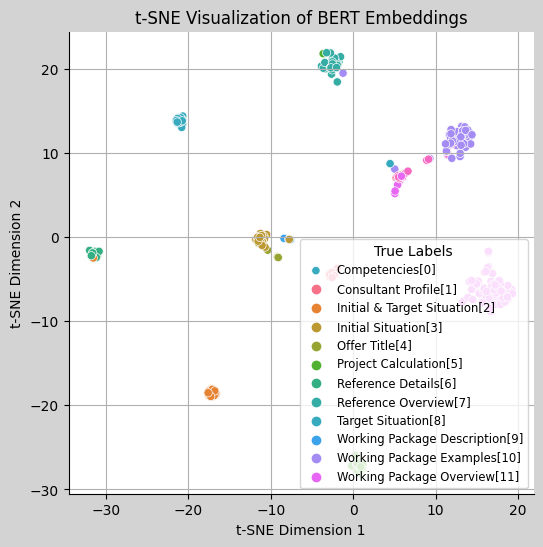

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Concatenate the embeddings and labels
embeddings = np.concatenate(predictions)
hue_labels = np.concatenate(true_labels)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Map true labels to corresponding class names
class_names = ['Competencies[0]', 'Consultant Profile[1]', 'Initial & Target Situation[2]',
               'Initial Situation[3]', 'Offer Title[4]', 'Project Calculation[5]',
               'Reference Details[6]', 'Reference Overview[7]', 'Target Situation[8]',
               'Working Package Description[9]', 'Working Package Examples[10]',
               'Working Package Overview[11]']

# Create a colormap for different classes
cmap = sns.color_palette("husl", n_colors=len(class_names))

# Use Seaborn to visualize the embeddings
plt.figure(figsize=(6, 6), facecolor='lightgray')  # 設定背景顏色為淺灰色
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=hue_labels,
                palette=cmap, legend='full',)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of BERT Embeddings')
plt.grid(True)
sns.despine()  # Remove spines from plot

# Move the legend to the bottom right corner
plt.legend(title='True Labels', labels=class_names, fontsize='small', loc='lower right')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

matthews_set = []

ground_true = []
preds = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input BATCH...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)
  print(pred_labels_i)
  print(true_labels[i])
  print('------')
  # extend for checking every label
  ground_true.extend(pred_labels_i)
  preds.extend(true_labels[i])

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.931


In [ ]:
# Generate the classification report
test_report = classification_report(ground_true, preds, target_names=['Competencies[0]',
                                                                      'Consultant Profile[1]',
                                                                      'Initial & Target Situation[2]',
                                                                      'Initial Situation[3]',
                                                                      'Offer Title[4]',
                                                                      'Project Calculation[5]',
                                                                      'Reference Details[6]',
                                                                      'Reference Overview[7]',
                                                                      'Target Situation[8]',
                                                                      'Working Package Description[9]',
                                                                      'Working Package Examples[10]',
                                                                      'Working Package Overview[11]'])

# Print the classification report
print(test_report)

                                precision    recall  f1-score   support

               Competencies[0]       0.96      1.00      0.98        26
         Consultant Profile[1]       0.97      1.00      0.98        31
 Initial & Target Situation[2]       0.87      0.96      0.92        28
          Initial Situation[3]       0.88      1.00      0.93         7
                Offer Title[4]       0.97      1.00      0.99        33
        Project Calculation[5]       1.00      0.97      0.98        29
          Reference Details[6]       1.00      0.93      0.96        40
         Reference Overview[7]       0.97      1.00      0.98        28
           Target Situation[8]       1.00      0.73      0.84        11
Working Package Description[9]       0.94      0.88      0.91        57
  Working Package Examples[10]       0.93      0.99      0.96        72
  Working Package Overview[11]       0.72      0.69      0.71        26

                      accuracy                           0.94 

# Visualization from `runs`

In [12]:
%load_ext tensorboard
%tensorboard --logdir=./output/runs --port=1003

# Befor fine-tuning model

In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels = 12)
# Copy the model to the GPU.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
from sklearn.metrics import classification_report
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(test_size))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in testing_dataloader:
  # Add batch to GPU
  # batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels=b_labels)


  loss = outputs.loss
  logits = outputs.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # predictions.extend(np.argmax(logits, axis=1))
  # true_labels.extend(label_ids)
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

# print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

print(predictions)
print(true_labels)

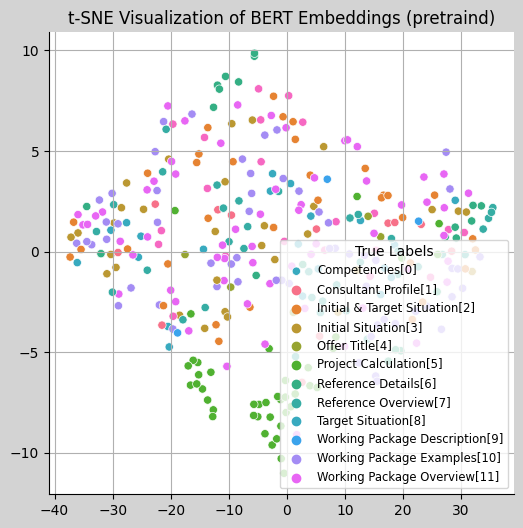

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Concatenate the embeddings and labels
embeddings = np.concatenate(predictions)
hue_labels = np.concatenate(true_labels)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Map true labels to corresponding class names
class_names = ['Competencies[0]', 'Consultant Profile[1]', 'Initial & Target Situation[2]',
               'Initial Situation[3]', 'Offer Title[4]', 'Project Calculation[5]',
               'Reference Details[6]', 'Reference Overview[7]', 'Target Situation[8]',
               'Working Package Description[9]', 'Working Package Examples[10]',
               'Working Package Overview[11]']

# Create a colormap for different classes
cmap = sns.color_palette("husl", n_colors=len(class_names))

# Use Seaborn to visualize the embeddings
plt.figure(figsize=(6, 6), facecolor='lightgray')
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=hue_labels,
                palette=cmap, legend='full',)
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of BERT Embeddings (pretraind)')
plt.grid(True)
sns.despine()  # Remove spines from plot

# Move the legend to the bottom right corner
plt.legend(title='True Labels', labels=class_names, fontsize='small', loc='lower right')

plt.show()